In [1]:
import import_ipynb
import i_creation_environnement
import numpy as np
import matplotlib.pyplot as plt

importing Jupyter notebook from i_creation_environnement.ipynb


In [2]:
env = i_creation_environnement.AugmentedGridworldEnv()

# Value Iteration

In [3]:
def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    V = np.zeros(env.nS)
    for i in range(1000):
        # Stopping condition
        delta = 0
        # Update each state...
        for s in range(env.nS):
            # Do a one-step lookahead to find the best action
            A = one_step_lookahead(s, V)
            best_action_value = np.max(A)
            # Calculate delta across all states seen so far
            delta = max(delta, np.abs(best_action_value - V[s]))
            # Update the value function. Ref: Sutton book eq. 4.10. 
            V[s] = best_action_value        
        # Check if we can stop 
        if delta < theta:
            print("")
            print(" --------- >       VALUE FUNCTION STABLE")
            break
            
        if i%30==0:
            print("Step :", i, "     Delta : ", delta)
            plt.imshow(V.reshape(env.shape))
            plt.show()
    
    # Create a deterministic policy using the optimal value function
    policy = np.zeros([env.nS, env.nA])
    for s in range(env.nS):
        # One step lookahead to find the best action for this state
        A = one_step_lookahead(s, V)
        best_action = np.argmax(A)
        # Always take the best action
        policy[s, best_action] = 1.0
    
    return policy, V

Step : 0      Delta :  97.5


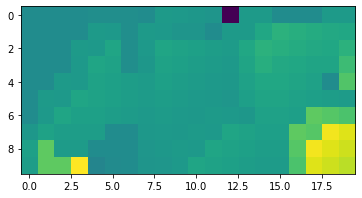

Step : 30      Delta :  10.731938197146974


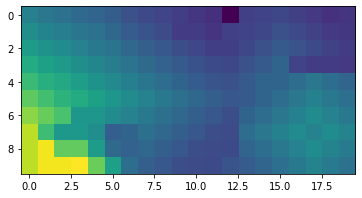

Step : 60      Delta :  2.303489949347636


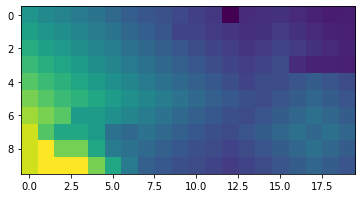

Step : 90      Delta :  0.4944182354830673


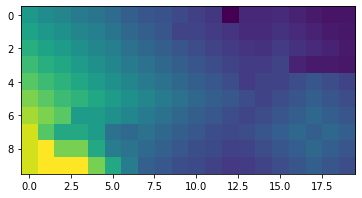

Step : 120      Delta :  0.1061213189349246


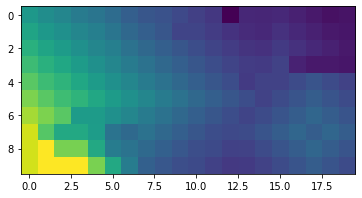

Step : 150      Delta :  0.02277774872425198


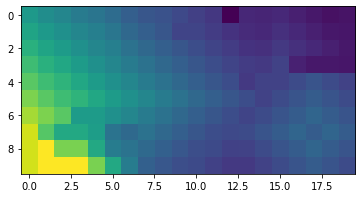

Step : 180      Delta :  0.004888987831577651


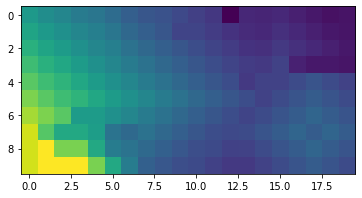

Step : 210      Delta :  0.001049366305210242


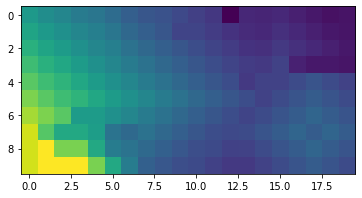

Step : 240      Delta :  0.00022523468680901715


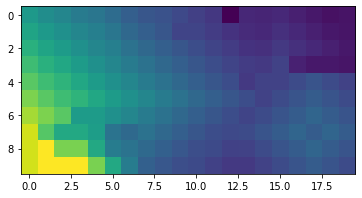


 --------- >       VALUE FUNCTION STABLE


In [4]:
policy_1, v_1 = value_iteration(env, discount_factor = 0.95)

### Final results for Value Iteration

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):

↓↓↓↓↓←↓↓↓←←←←↓↓↓↓↓→↓
↓↓↓↓↓←↓↓↓↓↓↓↓↓→↓↓↓↓↓
↓↓↓↓↓←↓↓↓↓↓↓↓↓→↓←←←←
↓↓↓↓↓↓↓↓↓↓←←←←→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓↓↓↓↓→→→↓↓↓↓
↓↓↓←←←←←←←←←←←→→→↓↓↓
↓←←↑↑↑↑↑↑↑↑↑↑←→→→↓↓↓
↓↓↓↓←↓↓↑↑↑↑↑←→→→→→←←
↓↓↓↓↓↓←←←←←←←→→→→↑↑↑
→→↓←←←←↑↑↑↑↑↑→→→→↑↑↑


Value Function:



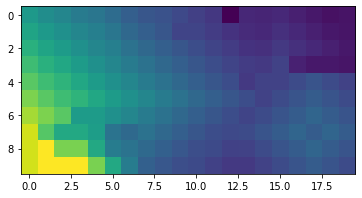

In [5]:
print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print("")
env.render_policy(np.reshape(np.argmax(policy_1, axis=1), env.shape))
print("")

print("Value Function:")
plt.imshow(v_1.reshape(env.shape))
print("")

# Policy Evaluation

In [6]:
def policy_eval(policy, env, discount_factor=0.99, theta=0.000001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    
    # Start with a random (all 0) value function

    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):  # for all the states
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    
                    # Calculate the expected value. Ref: Sutton book eq. 4.6.
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
                    
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
            
        # Stop evaluating once our value function change is below a threshold
        #print(delta)
        if delta < theta:
            break
    return np.array(V), delta

In [7]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
v, delta = policy_eval(random_policy, env, 0.9)

In [8]:
print("Reshaped Grid Value Function:")
vv = v.reshape(env.shape)

np.set_printoptions( threshold=20, edgeitems=10, linewidth=140,formatter = dict( float = lambda x: "%.3g" % x )) 

print(np.around(vv, 2))

Reshaped Grid Value Function:
[[-14.7 -14.1 -12.7 -9.8 -5.11 -7.33 -25.2 -58.7 -116 -222 -346 -446 -482 -412 -304 -197 -112 -73.8 -48.9 -28.8]
 [-17.4 -16.9 -15.3 -11.5 -4.46 -7.13 -25 -56.6 -126 -298 -298 -373 -359 -311 -227 -148 -110 -88.8 -73.8 -53.8]
 [-23.8 -23.7 -22.4 -17.3 -12.1 -6.28 -25.9 -49.8 -84.6 -148 -194 -222 -215 -171 -143 -132 -136 -133 -144 -115]
 [-36.6 -37.7 -39 -38.5 -28.6 -34.5 -36.8 -49.7 -60.3 -74.9 -81.5 -89.5 -91.1 -96.6 -115 -153 -226 -216 -216 -230]
 [-60.1 -63.7 -70.2 -81.9 -85.5 -84.5 -84.7 -69.4 -54.5 -38.8 -31.5 -22.2 -32.7 -48.1 -115 -115 -171 -206 -269 -261]
 [-102 -111 -135 -165 -181 -202 -181 -115 -69.4 -39.8 -16.1 -6.73 -2.82 -22.6 -46.4 -66.8 -97.3 -146 -179 -187]
 [-177 -199 -250 -345 -345 -338 -288 -187 -94.4 -48.2 -21.8 -7.63 -3.56 -6.05 -21.1 -33.9 -44 -53 -78.3 -89.9]
 [-302 -344 -438 -438 -445 -442 -350 -221 -110 -53.9 -20.6 -9.55 -2.04 -3.27 -10.3 -14.5 -6.94 -18.9 -21.9 -39.8]
 [-328 -400 -493 -493 -530 -498 -381 -219 -116 -56.3 -26.2 -7.76

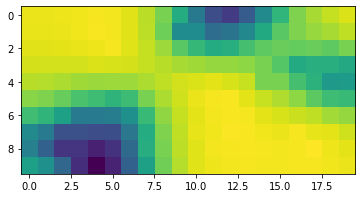

In [9]:
plt.imshow(vv)

# Policy Iteration

In [10]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI environment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    
    

    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.nA)
        for a in range(env.nA):
            for prob, next_state, reward, done in env.P[state][a]:
                A[a] += prob * (reward + discount_factor * V[next_state])
        return A
    
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA
    ancient_V = np.zeros(env.nS)

    #while True:
    for i in range(30):
        
        # Evaluate the current policy
        V, delta = policy_eval_fn(policy, env, discount_factor)
        print("###############################    STEP  : ", i, "   ##############################")
        # Will be set to false if we make any changes to the policy
        policy_stable = True
        
        # For each state...
        for s in range(env.nS):
            # The best action we would take under the current policy
            chosen_a = np.argmax(policy[s])
            
            # Find the best action by one-step lookahead
            # Ties are resolved arbitarily
            action_values = one_step_lookahead(s, V)
            best_a = np.argmax(action_values)
            
            # Greedily update the policy
            if chosen_a != best_a:
                policy_stable = False
            policy[s] = np.eye(env.nA)[best_a]
        
        # If the policy is stable we've found an optimal policy. Return it
        if policy_stable :
            print("")
            print("----------> STABLE POLICY")
            return policy, V
        
        print("")
        print("CURRENT POLICY")
        env.render_policy(np.reshape(np.argmax(policy, axis=1), env.shape))
        print("")
        
        print("DIFFERENCES WITH PREVIOUS VALUE FUNCTION")
        plt.imshow(np.reshape(V - ancient_V, env.shape))
        plt.show()
        print("")
        
        print("CURRENT VALUE FUNCTION")
        plt.imshow(np.reshape(V, env.shape))
        plt.show()
        print("")
        print("")
        
    
        ancient_V = V
        
        #rint(np.reshape(np.argmax(policy, axis=1), env.shape))
        #rint(V.reshape(env.shape))
        
    return policy, V

###############################    STEP  :  0    ##############################

CURRENT POLICY
→→→→→↑←←←←←←↓↓→→→→→↑
↑↑→→→↑←←←↓↓↓↓↓↓→→→→↑
↑↑↑→→↑←←←↓↓↓↓↓↓→↑↑↑↑
↑↑↑↑→↑←←←↓↓↓↓↓←↑↑↑↑↑
↑↑↑↑↑↑↑↑→→→→←↓↓↓↓↓↓↓
↑↑↑↑↑↑↑↑→→↑↑↑↓←↓↓↓↓↓
↑↑↑↑↑↑↑→→→→→→↑←↓↓↓↓↓
↑↑↑↑↑↑→→→→→→→↑←←→↓←↓
↓↓↑↑→→→→→→→→→↑←←←↑←↓
↓←←←→→→→→→→→→↑←←←←←←


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


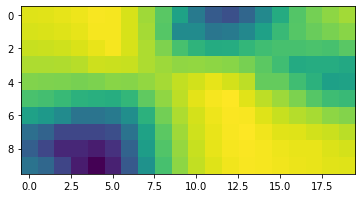


CURRENT VALUE FUNCTION


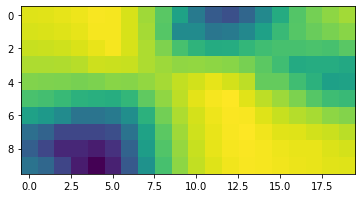



###############################    STEP  :  1    ##############################

CURRENT POLICY
→→→→→↑←←↓↓←←→→→→→→→↓
↑→→↓↓↑←→←↓↓↓→→→→→→→↓
↑→→→←←←←↑→↓↓↓↑→→→→→↓
↑→→↑↑↑←←→→↓↓↓↓→↓↓↓↓→
↑→→↑←↑↑↑→→→→←↓→→↓↓↓←
↑→→↑←↑↑↑↑↑↑↑↑↓←→→↓↓←
↑→↑↑↑↑↑↓↓↓↓↓→↑←→→↓↓←
↓↑↑↑↑↓→→→→→←←↑←→→→←←
↑↓↑↑→→→→→→↑↑→↑←←→↑↑←
↓→↓←←↑↑↑↑↑↑↑↑↑↑↑↑↑↑←


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


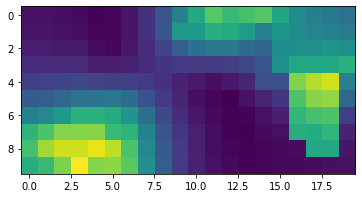


CURRENT VALUE FUNCTION


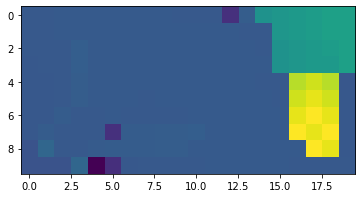



###############################    STEP  :  2    ##############################

CURRENT POLICY
→↓↓↓↓↑←→↓←←←↓↓↓→→→→↑
→→→→↓←→→↑↓↓→→→←→→→→↑
→→→→↑←←↑↑←↓↓→↑↓↓↓↓→↑
→↑↑↑↑←←←↑→↓↓↓→→↓↓↓↓↑
→↓↓↑↑←↑↑→→→→←→→→↓↓↓↓
→→↓←↑←↑↓↓↓↓↓↑↓→→→↓↓↓
↓↑↑↑↑←→→→→→↓↓↑→→→↓↓↓
↓↑↑↑↑↓→→→→→↑←←→→→↑←←
↓↓↓↓↓→→→→→↑↑↑↑←↑↑↑↑↑
→→↓←←←↑↑↑↑↑↑←↑↑→↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


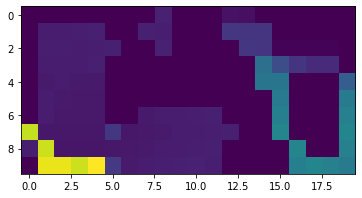


CURRENT VALUE FUNCTION


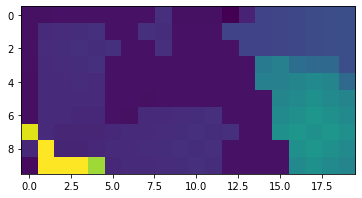



###############################    STEP  :  3    ##############################

CURRENT POLICY
→→→→↓←→→↓←←←→↓↓→→→→↓
→→→→↓←→→↑↑↑→→→↓↓↓↓→↓
→→→→↑←↑↑↑←←→→→→↓←←←↓
↓↓↓↑↑←←↑↑↑↓↓→→→↓↓↓↓↓
→→↓↓↑←←↓↑↓↓↓→→→→↓↓↓↓
↓→↑←←↑←→→→→↓↓→→→→↓↓↓
↓←↑↑↑↑→→→→→↓↓→→→→↓↓↓
↓↓↓↓↓↓→→→→→↑←→→→→↑←←
↓↓↓↓↓↓→→→→↑↑↑←↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑↑←→↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


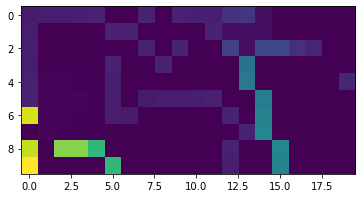


CURRENT VALUE FUNCTION


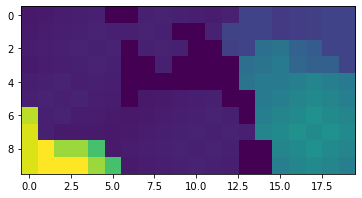



###############################    STEP  :  4    ##############################

CURRENT POLICY
→→→→↓←→→↓←←→→↓↓↓↓↓→↓
→→→→↓←→→↑→→↓→→→↓↓↓↓↓
→→→→↑←↑↑↑←→→→→→↓←←←←
→→↓↑↑←↑↑↑↑↑→→→→↓↓↑↑↓
↓→↓↓↑←←↑↑↑↓↓→→→→↓↓↓↓
↓↓↑←←←↑→↑→→↓↓→→→→↓↓↓
↓←←↓↓↓↑→→→→↓↓→→→→↓↓↓
↓↓↓↓←↓←→→→→↑←→→→→↑←←
↓↓↓↓↓↓←→→→↑↑↑→↑↑↑↑↑↑
→→↓←←←←←↑↑↑↑↑→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


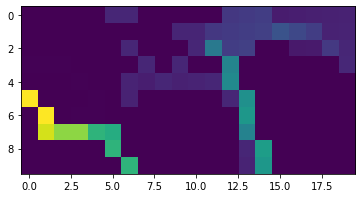


CURRENT VALUE FUNCTION


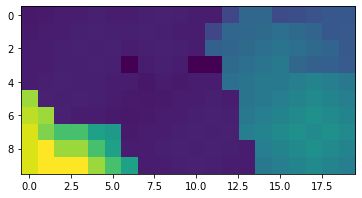



###############################    STEP  :  5    ##############################

CURRENT POLICY
→→→→↓←→→↓↓←↓→↓↓↓↓↓→↓
→→→→↓←→→→↓↓↓→→→↓↓↓↓↓
→→→→↑←↑↑↑→→→→→→↓←←←←
↓→↓↑↑←↑↑↑→→→→→→↓↓↑↑↑
↓↓↓↓↑←←↑↑↑↑↑→→→→↓↓↓↓
↓↓↓↓↓↓←↑↑→→↓↓→→→→↓↓↓
↓←←↓↓←↓→→→→↓↓→→→→↓↓↓
↓↓↓↓←↓↓←→→→↑←→→→→↑←←
↓↓↓↓↓↓←←→→↑↑↑→↑↑↑↑↑↑
→→↓←←←←←←↑↑↑→→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


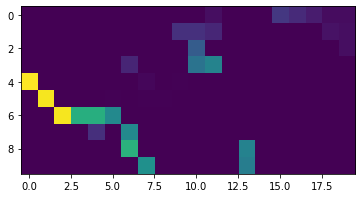


CURRENT VALUE FUNCTION


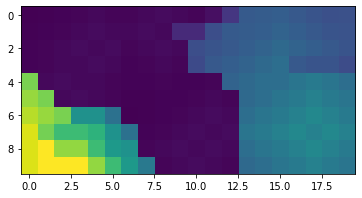



###############################    STEP  :  6    ##############################

CURRENT POLICY
→→→→↓→→→↓↓←←→↓↓↓↓↓→↓
→→→→↓→→→→↓↓↓→→→↓↓↓↓↓
↓↓↓→↑→→↑→→→→→→→↓←←←←
↓↓↓←↑→→↑→→→→→→→↓↓↑↑↑
↓↓↓←↓↓↓↑→↑↑↑→→→→↓↓↓↓
↓↓↓←↓←←←↑↑→↓↓→→→→↓↓↓
↓←←↓↓←↓↓↑→→↓↓→→→→↓↓↓
↓↓↓↓←↓↓↓←→→↑←→→→→↑←←
↓↓↓↓↓↓←←←→↑↑↓→↑↑↑↑↑↑
→→↓←←←←↑←←↑→→→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


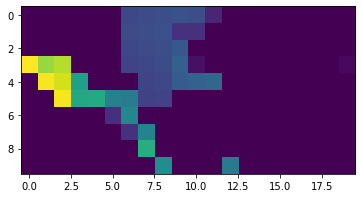


CURRENT VALUE FUNCTION


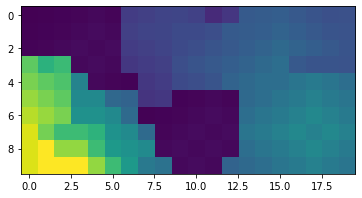



###############################    STEP  :  7    ##############################

CURRENT POLICY
→→→→↓→→→↓↓←←→↓↓↓↓↓→↓
↓↓↓→↓→→→→↓↓↓→→→↓↓↓↓↓
↓↓↓↓↑→→→→→→→→→→↓←←←←
↓↓↓↓←↓↓→→→→→→→→↓↓↑↑↑
↓↓↓↓←↓↓↓→↑↑↑→→→→↓↓↓↓
↓↓↓←←←←↓←↑←↓↓→→→→↓↓↓
↓←←↓↓←→↓↓↑→↓↓→→→→↓↓↓
↓↓↓↓←↓↓↓↓←→↑↓→→→→↑←←
↓↓↓↓↓↓←←←←↑→↓→↑↑↑↑↑↑
→→↓←←←←↑↑←←→→→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


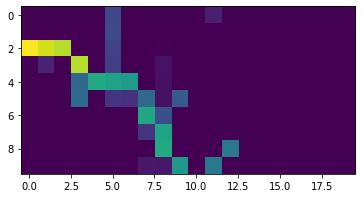


CURRENT VALUE FUNCTION


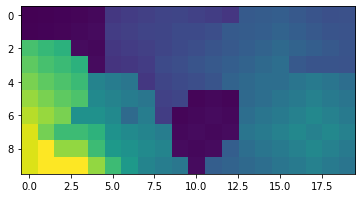



###############################    STEP  :  8    ##############################

CURRENT POLICY
↓↓↓→↓→→→↓↓←←→↓↓↓↓↓→↓
↓↓↓↓↓→→→→↓↓↓→→→↓↓↓↓↓
↓↓↓↓↓→↓→→→→→→→→↓←←←←
↓↓↓↓↓↓↓←→→→→→→→↓↓↑↑↑
↓↓↓↓↓↓↓←↓↑↑↑→→→→↓↓↓↓
↓↓↓←←←←←↓←←→↓→→→→↓↓↓
↓←←↑↑↑↑↓↓↓↑→↓→→→→↓↓↓
↓↓↓↓←↓↓↓↓↓←→↓→→→→↑←←
↓↓↓↓↓↓←←←←←→↓→↑↑↑↑↑↑
→→↓←←←←↑↑↑←←→→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


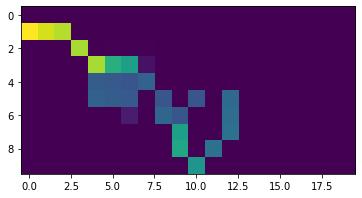


CURRENT VALUE FUNCTION


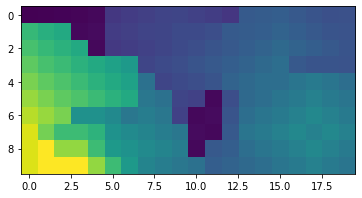



###############################    STEP  :  9    ##############################

CURRENT POLICY
↓↓↓↓↓←→→↓↓←←→↓↓↓↓↓→↓
↓↓↓↓↓←↓→→↓↓↓→→→↓↓↓↓↓
↓↓↓↓↓←↓↓→→→→→→→↓←←←←
↓↓↓↓↓↓↓↓←→→→→→→↓↓↑↑↑
↓↓↓↓↓↓↓↓←↓↓↑→→→→↓↓↓↓
↓↓↓←←←←←←↓←←↓→→→→↓↓↓
↓←←↑↑↑↑↑↓↓↓←↓→→→→↓↓↓
↓↓↓↓←↓↓↓↓↓↓←↓→→→→↑←←
↓↓↓↓↓↓←←←←←←↓→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑←←→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


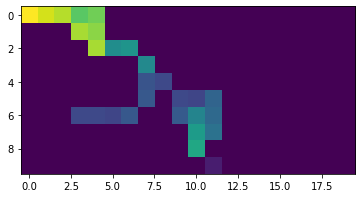


CURRENT VALUE FUNCTION


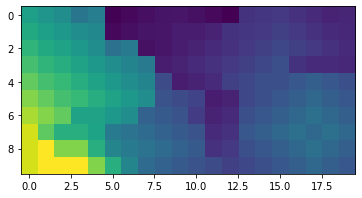



###############################    STEP  :  10    ##############################

CURRENT POLICY
↓↓↓↓↓←↓→↓↓←←→↓↓↓↓↓→↓
↓↓↓↓↓←↓↓→↓↓↓→→→↓↓↓↓↓
↓↓↓↓↓←↓↓↓→→→→→→↓←←←←
↓↓↓↓↓↓↓↓↓←→→→→→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓←↓↓→→→→↓↓↓↓
↓↓↓←←←←←←←↓↓←→→→→↓↓↓
↓←←↑↑↑↑↑↑↓↓↓←→→→→↓↓↓
↓↓↓↓←↓↓↑↓↓↓↓←→→→→↑←←
↓↓↓↓↓↓←←←←←←←→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑←→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


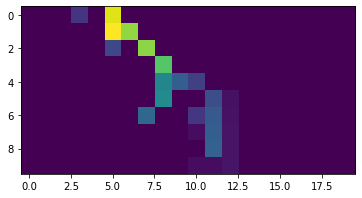


CURRENT VALUE FUNCTION


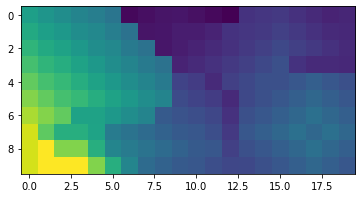



###############################    STEP  :  11    ##############################

CURRENT POLICY
↓↓↓↓↓←↓↓↓↓←←→↓↓↓↓↓→↓
↓↓↓↓↓←↓↓↓↓↓↓→→→↓↓↓↓↓
↓↓↓↓↓←↓↓↓↓→→→→→↓←←←←
↓↓↓↓↓↓↓↓↓↓←→→→→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓↓←↓→→→→↓↓↓↓
↓↓↓←←←←←←←←↓↓→→→→↓↓↓
↓←←↑↑↑↑↑↑↑↓↓↓→→→→↓↓↓
↓↓↓↓←↓↓↑↑↓↓↓←→→→→↑←←
↓↓↓↓↓↓←←←←←←←→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑↑→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


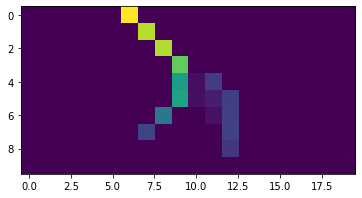


CURRENT VALUE FUNCTION


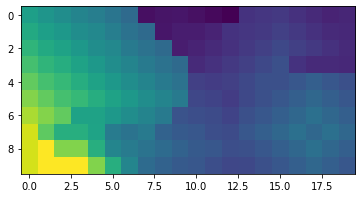



###############################    STEP  :  12    ##############################

CURRENT POLICY
↓↓↓↓↓←↓↓↓←←←→↓↓↓↓↓→↓
↓↓↓↓↓←↓↓↓↓↓↓→→→↓↓↓↓↓
↓↓↓↓↓←↓↓↓↓↓→→→→↓←←←←
↓↓↓↓↓↓↓↓↓↓←←→→→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓↓↓↓→→→→↓↓↓↓
↓↓↓←←←←←←←←←↓→→→→↓↓↓
↓←←↑↑↑↑↑↑↑↑↓↓→→→→↓↓↓
↓↓↓↓←↓↓↑↑↑↓↓←→→→→↑←←
↓↓↓↓↓↓←←←←←←←→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑↑→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


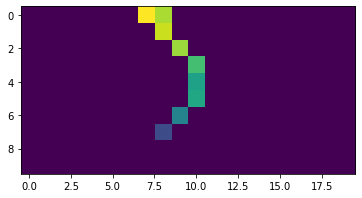


CURRENT VALUE FUNCTION


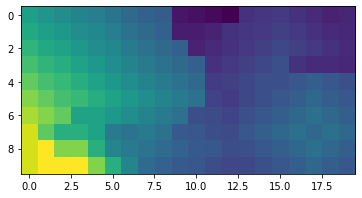



###############################    STEP  :  13    ##############################

CURRENT POLICY
↓↓↓↓↓←↓↓↓←←←←↓↓↓↓↓→↓
↓↓↓↓↓←↓↓↓↓↓↓→→→↓↓↓↓↓
↓↓↓↓↓←↓↓↓↓↓↓→→→↓←←←←
↓↓↓↓↓↓↓↓↓↓←←←→→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓↓↓↓→→→→↓↓↓↓
↓↓↓←←←←←←←←←←→→→→↓↓↓
↓←←↑↑↑↑↑↑↑↑↑↓→→→→↓↓↓
↓↓↓↓←↓↓↑↑↑↑↓←→→→→↑←←
↓↓↓↓↓↓←←←←←←←→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑↑→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


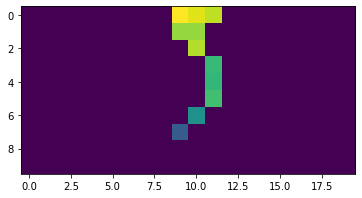


CURRENT VALUE FUNCTION


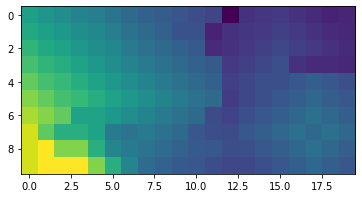



###############################    STEP  :  14    ##############################

CURRENT POLICY
↓↓↓↓↓←↓↓↓←←←←↓↓↓↓↓→↓
↓↓↓↓↓←↓↓↓↓↓↓→→→↓↓↓↓↓
↓↓↓↓↓←↓↓↓↓↓↓↓→→↓←←←←
↓↓↓↓↓↓↓↓↓↓←←←←→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓↓↓↓↓→→→↓↓↓↓
↓↓↓←←←←←←←←←←←→→→↓↓↓
↓←←↑↑↑↑↑↑↑↑↑↑→→→→↓↓↓
↓↓↓↓←↓↓↑↑↑↑↑←→→→→↑←←
↓↓↓↓↓↓←←←←←←←→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑↑→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


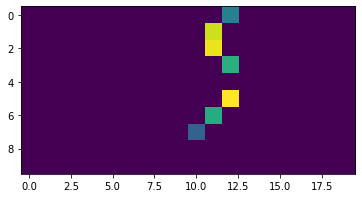


CURRENT VALUE FUNCTION


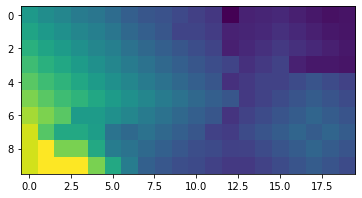



###############################    STEP  :  15    ##############################

CURRENT POLICY
↓↓↓↓↓←↓↓↓←←←←↓↓↓↓↓→↓
↓↓↓↓↓←↓↓↓↓↓↓↓→→↓↓↓↓↓
↓↓↓↓↓←↓↓↓↓↓↓↓↓→↓←←←←
↓↓↓↓↓↓↓↓↓↓←←←←→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓↓↓↓↓→→→↓↓↓↓
↓↓↓←←←←←←←←←←←→→→↓↓↓
↓←←↑↑↑↑↑↑↑↑↑↑←→→→↓↓↓
↓↓↓↓←↓↓↑↑↑↑↑←→→→→↑←←
↓↓↓↓↓↓←←←←←←←→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑↑→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


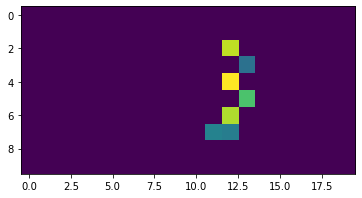


CURRENT VALUE FUNCTION


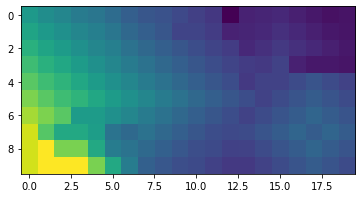



###############################    STEP  :  16    ##############################

CURRENT POLICY
↓↓↓↓↓←↓↓↓←←←←↓↓↓↓↓→↓
↓↓↓↓↓←↓↓↓↓↓↓↓↓→↓↓↓↓↓
↓↓↓↓↓←↓↓↓↓↓↓↓↓→↓←←←←
↓↓↓↓↓↓↓↓↓↓←←←←→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓↓↓↓↓→→→↓↓↓↓
↓↓↓←←←←←←←←←←←→→→↓↓↓
↓←←↑↑↑↑↑↑↑↑↑↑←→→→↓↓↓
↓↓↓↓←↓↓↑↑↑↑↑←→→→→↑←←
↓↓↓↓↓↓←←←←←←←→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑↑→↑↑↑↑↑↑


DIFFERENCES WITH PREVIOUS VALUE FUNCTION


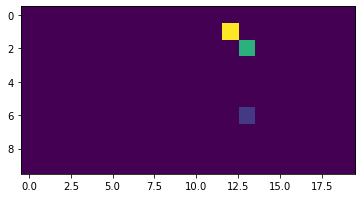


CURRENT VALUE FUNCTION


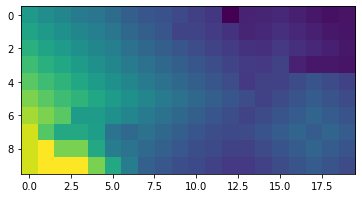



###############################    STEP  :  17    ##############################

----------> STABLE POLICY


In [11]:
policy_2, v_2 = policy_improvement(env, discount_factor = 0.95)

### Final results for Policy Iteration

Final policy

↓↓↓↓↓←↓↓↓←←←←↓↓↓↓↓→↓
↓↓↓↓↓←↓↓↓↓↓↓↓↓→↓↓↓↓↓
↓↓↓↓↓←↓↓↓↓↓↓↓↓→↓←←←←
↓↓↓↓↓↓↓↓↓↓←←←←→↓↓↑↑↑
↓↓↓↓↓↓↓↓↓↓↓↓↓→→→↓↓↓↓
↓↓↓←←←←←←←←←←←→→→↓↓↓
↓←←↑↑↑↑↑↑↑↑↑↑←→→→↓↓↓
↓↓↓↓←↓↓↑↑↑↑↑←→→→→↑←←
↓↓↓↓↓↓←←←←←←←→↑↑↑↑↑↑
→→↓←←←←↑↑↑↑↑↑→↑↑↑↑↑↑

Final Value Function:


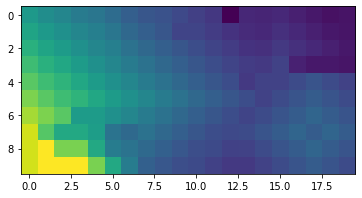

In [12]:
print("Final policy")
print("")
env.render_policy(np.reshape(np.argmax(policy_2, axis=1), env.shape))

print("Final Value Function:")
plt.imshow(v_2.reshape(env.shape))

## Comments : 
- With a discount rate of 0.95, the policy is stable at the end... it's not the case with smaller discount rates (like 0.9 for example). 
- We need 16 steps to get the optimal policy and we therefore can say that the initial value function estimation (found with the random policy) wasn't the optimal one. 


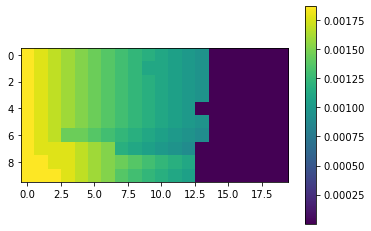

In [13]:
plt.imshow((v_2 - v_1).reshape(env.shape))
plt.colorbar()

- the value function given by Policy Iteration slightly differs from the one given by Value Iteration

In [14]:
np.reshape(np.argmax(policy_2, axis=1) - np.argmax(policy_1, axis=1), env.shape)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0]], dtype=int64)

#### - And those little differences in the value function are sufficient to generate different policies ! (Bottom right zone)